## Imports

In [1]:
# utils
import os
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import numpy as np
import pandas as pd
from tqdm import tqdm

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_agg import FigureCanvasAgg

# metrics
from utils import config
from utils.reader import read_file_yaml

np.random.seed(0)

## Reading datasets

In [2]:
path_root = (
    PROJECT_DIR
    / "results"
)
path_outputs = (
    PROJECT_DIR
    / "outputs"
)
path_conf = (
    PROJECT_DIR
    / "conf"
)
file_path_parameters = (
    path_conf 
    / "parameters.yml"
)

params = read_file_yaml(file_path_parameters)
     
n_random = np.sort([int(i.replace("random_n",""))for i in os.listdir(path_root) if ".placehold"not in i])
path_random = [
    "random_n"+str(i) for i in n_random
]
path_results = [path_root / i for i in path_random]

ext_type = params["outputs"]["extension_type"]
ext_local_img = params["outputs"]["extension_local_img"]
ext_best_img = params["outputs"]["extension_best_img"]

In [3]:
file_path_corr = {
    str(i).split("/")[-1]: {
        j: {
            "url": i / j / "correlation",
            "file": i / j / "correlation" / Path(j + "_corr_spearman" + ext_type)
           } for j in config.file_names # os.listdir(i)
    } for i in path_results
}

file_path_metrics = {
    str(i).split("/")[-1]: {
        j: {
            "file": i / j / "metrics" / Path("metrics" + ext_type)
           } for j in config.file_names# os.listdir(i)
    } for i in path_results
}

In [4]:
data_metrics = {
    i_random: {
        j_name: pd.read_csv(
            j_content["file"], 
            index_col = 0
        ) for j_name, j_content in i_content.items()
    } for i_random, i_content in file_path_metrics.items()
}

## Generate correlations

In [5]:
data_corr = {}

for i_random, i_content in tqdm(file_path_corr.items()):
    data_corr[i_random] = {}
    for j_name, j_content in tqdm(i_content.items()):
        if j_name == "no_structure":
            continue
        
        if not os.path.exists(j_content["url"]):
            os.makedirs(j_content["url"])
            
        data_corr[i_random][j_name] = data_metrics[i_random][j_name].copy()
        data_corr[i_random][j_name].dropna(inplace = True)
        data_corr[i_random][j_name] = data_corr[i_random][j_name].corr(method = params["correlation_method"])
        data_corr[i_random][j_name].to_csv(j_content["file"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 167.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 108.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 127.25it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 17/35 [00:01<00:02,  8.68it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 123.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 165.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 193.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 193.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [35]:
for i_random, i_content in list(file_path_corr.items()):
    for j_name, j_content in i_content.items():
        if "no_structure" in j_name:
            continue
        url = (
            j_content["url"] / Path(j_name + "_corr_spearman" + ext_local_img)
        )
        figure = plt.figure(figsize=(15, 8))
        sns.set(font_scale=1)
        sns.heatmap(data_corr[i_random][j_name], annot=True, cmap="crest")
        #plt.ioff()
        plt.savefig(url)

## Generate table results

In [6]:
tmp = {}
tmp_groupby = {}
for i_random, i_content in data_corr.items():
    tmp[i_random] = {}
    for j_name, j_content in i_content.items():
        tmp[i_random][j_name] = j_content.reset_index().rename(columns={"index": "metrics"})
        tmp[i_random][j_name].insert(0, "dataset", [j_name] * tmp[i_random][j_name].shape[0])
    tmp[i_random] = pd.concat(list(tmp[i_random].values()), ignore_index=True)
    tmp[i_random] = tmp[i_random][
        ~tmp[i_random].metrics.str.contains("abilities")
    ]  # .groupby(['dataset', 'metrics']).mean()
    tmp_groupby[i_random] = tmp[i_random].groupby(['dataset','metrics']).mean()[['abilities']]

## Correlation for each dataset with abilities

In [7]:
data_unique = {}
for i_random, i_content in data_corr.items():
    first = list(i_content.keys())[0]
    data_unique[i_random] = pd.DataFrame(
        columns = i_content.keys(),
        index = i_content[first].columns[1:]
    )

In [8]:
data_unique = {}
for i_random, i_content in data_corr.items():
    data_unique[i_random] = {}
    for j_name, j_content in i_content.items():
        if j_name != "no_structure":
            data_unique[i_random][j_name] = (
                j_content.drop(j_content.columns[1:], axis=1)
                .drop(["abilities"], axis=0)
                .rename(columns={"abilities": j_name})
            )

In [9]:
data_grouped = {}
for j_random, j_content in data_unique.items():
    data_grouped[j_random] = {}
    for idx, (i_name, i_content) in enumerate(data_unique[j_random].items()):
        if idx == 0:
            data_pivot = i_content.copy()
        else:
            data_pivot = data_pivot.reset_index().merge(
                i_content.reset_index(),
                on = "index", 
                how = "inner"
            ).rename(columns = {"index": None}).set_index(None)
    data_grouped[j_random] = data_pivot.copy()

In [10]:
for i_random, i_content in data_grouped.items():
    data_grouped[i_random].columns = (
        data_grouped[i_random]
        .columns
        .str
        .replace("_", " ")
        .str
        .title()
    )
    data_grouped[i_random].rename(
        index = {
            "v_measure": "$v$",
            "calinski_harabasz": "$CH$",
            "silhouette": "$S$",
            "mutual_info": "$MI$",
            "adjusted_rand_score": "$ARI$",
            "davies_bouldin": "$DB$"
        },
        inplace = True
    )

In [31]:
figs_heatmap, axes = {}, {}
for i_random, i_content in data_grouped.items():    
    fig = plt.figure(figsize=(66, 25))
    ax = sns.heatmap(
        i_content,
        annot=True,
        cmap="crest",
        vmin=-1,
        vmax=1,
        annot_kws={"size": 45},
    )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=52)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=52)
    figs_heatmap[i_random] = fig
    axes[i_random] = ax
    plt.ioff()
    fig.savefig(
        path_outputs / Path(i_random + "_" + "abilities_corr_spearman" + ext_best_img), format=ext_best_img[1:]
    )

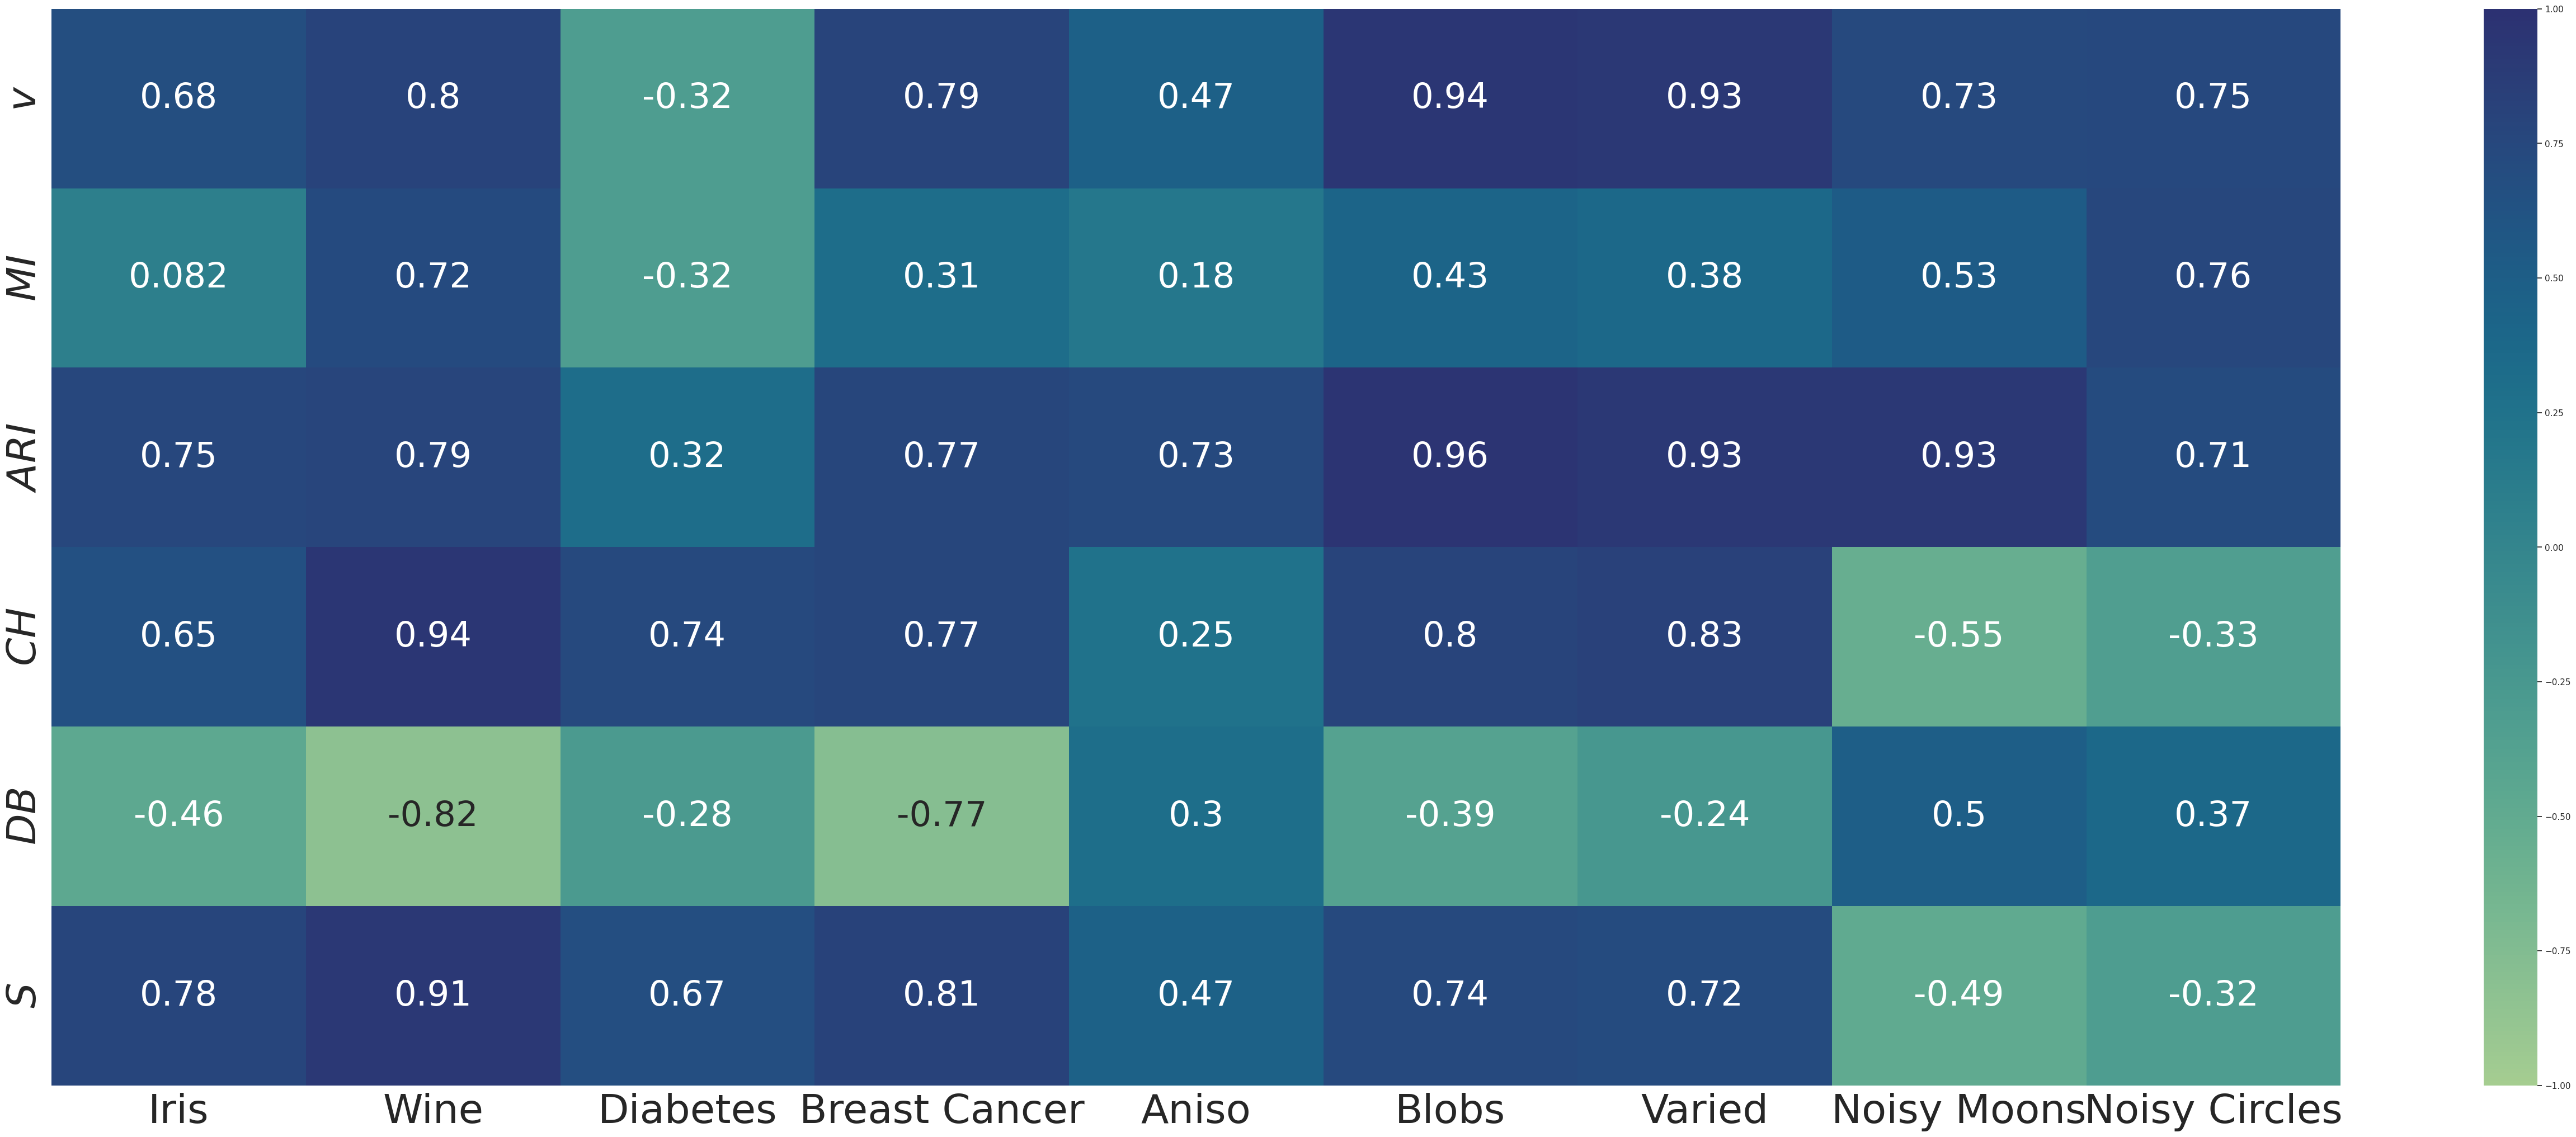

In [32]:
figs_heatmap[i_random]